In [1]:
# importing required libraries
import numpy as np
import tensorflow as tf
import time
import random
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import *

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

In [2]:
# required libraries for evaluation metrics

!pip -q install coclust
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from coclust.evaluation.external import accuracy

In [3]:
# The random pair generator class

class dataGenerator(tf.keras.utils.Sequence):
    """ Recieves X and y 
        Performes pairwise matching with a batch size 
        both pairs are generated from the input X and y
    """
    def __init__(self, X, y, alpha, validation_data=None, batch_size=64):
        self.batch_size  = batch_size                               # Training batch size
        self.inputX      = X                                        # Input data
        self.inputY      = y                                        # Input data label
        if self.inputY.shape[-1] == 1:
            self.inputY = self.inputY.reshape(self.inputY.shape[0])
        self.total       = len(X)                                   # Total data length
        self.alpha       = alpha
        # Generates label : indexes_where_label_found
        self.class_index = dict([(label, list(np.where(self.inputY == label)[0])) \
                                 for label in np.unique(self.inputY)])  
        self.indexes     = np.arange(self.total)
        self.total_batch = self.total // self.batch_size 
        self.classes = len(np.unique(self.inputY))
        self.on_epoch_end()
        

    def __len__(self):
        """ Denotes the number of batches per epoch """
        return int(self.total // self.batch_size)

    def __getitem__(self, index):
        """ Generate one batch of data """
        indexes1 = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        indexes2 = np.zeros(self.batch_size, dtype=np.int32)
        constraint = np.zeros(self.batch_size, dtype=np.int32)

        for i in range(self.batch_size):
            label = self.inputY[indexes1[i]]
            # Take same class-pair if True
            if random.choices([True, False], weights=[0.5, 0.5])[0] == True:
                indexes2[i] = random.choice(self.class_index[label])
            else:
                choice = label
                while label == choice:
                    label = random.randint(0, self.classes-1)
                indexes2[i] = random.choice(self.class_index[label])
                constraint[i] = self.alpha
        
        return [self.inputX[indexes1], self.inputX[indexes2]], constraint

    def on_epoch_end(self):
        """ Updates indexes after each epoch """
        np.random.shuffle(self.indexes)


# The logger that implements logging and saving params
class MyLogger(tf.keras.callbacks.Callback):
    def __init__(self, n=1, validation_data=None):
        self.n = n   # print loss & acc every n epochs
        if validation_data != None:
            self.x_val, self.y_val = validation_data
            self.classes = len(np.unique(self.y_val))
        self.start_time = time.time()
        self.epoch = 0
        self.savelog = {'Epoch': [], 'ACC':[], 'NMI':[], 'ARI':[]}
        
    def on_epoch_end(self, epoch, logs={}):
        if self.epoch % self.n != 0: return
        self.epoch += 1

        acc, nmi, ari = self._KmeansAcc()
        ep_time = time.time() - self.start_time
        self.start_time = time.time()
        print(f"\rEpoch {self.epoch}: ACC {acc:.5f} NMI {nmi:.5f} ARI {ari:.5f} Time:{ep_time:.1f}",
              end='')
        self._saveLog(self.epoch, acc, nmi, ari)

    def _saveLog(self, epoch, acc, nmi, ari):        
        self.savelog['Epoch'].append(epoch)
        self.savelog['ACC'].append(acc)
        self.savelog['NMI'].append(nmi)
        self.savelog['ARI'].append(ari)
            
    def _KmeansAcc(self):
        kmeans = KMeans(n_clusters=self.classes, n_jobs=-1, n_init=10)
        AE = self.model.layers[2]
        rindex = np.random.randint(0, self.y_val.shape[0], size=1000)
        outs = AE.predict(self.x_val[rindex])
        y_pred = kmeans.fit_predict(outs)
        acc = accuracy(self.y_val[rindex], y_pred)
        nmi = normalized_mutual_info_score(self.y_val[rindex], y_pred)
        ari = adjusted_rand_score(self.y_val[rindex], y_pred)
        return (acc, nmi, ari)

In [4]:
# Implementation of the distance layer
# We are assuming that the dimenstion of both of the embedders are 
# already subtracted
class Distance(Layer):
    def __init__(self, ):
        super(Distance, self).__init__()
        
    def call(self, inputs):
        return tf.expand_dims(
               tf.math.sqrt(
               tf.math.reduce_sum(
               tf.math.square(inputs), axis=1)), axis=-1)
        

# Implementation of the AutoEmbedder
def buildAE(input_shape, dims, alpha=100, topmodel='MobileNet'):
    inp1 = Input(input_shape, name='inp1')
    inp2 = Input(input_shape, name='inp2')

    model_str = topmodel + \
              "(input_shape=input_shape, include_top=False, weights='imagenet')"
    m1 = Sequential([eval(model_str), Flatten(), Dense(dims)])
    m2 = Sequential([eval(model_str), Flatten(), Dense(dims)])

    # Initializing two models with same weights
    m1.set_weights(m2.get_weights())
    out1 = m1(inp1)
    out2 = m2(inp2)

    # Subtracting output pairs
    out = Subtract()([out1, out2])
    # Calculating distance
    out = Distance()(out)
    # The thresholded ReLU layer
    out = ReLU(max_value=alpha)(out)

    # Initializing model
    model = Model([inp1, inp2], out)
    # Using default adam optimizer with mean square error
    model.compile(optimizer='adam', loss='mse')

    model_AE1 = Model(inp1, out1)
    model_AE2 = Model(inp2, out2)

    return model, model_AE1, model_AE2

In [5]:
model, AE1, AE2 = buildAE((32, 32, 3), dims=3, alpha=100, topmodel='MobileNet')

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

In [ ]:
dg = dataGenerator(x_train, y_train, alpha=100, batch_size=128)
log = MyLogger(validation_data=(x_test, y_test), n=1)
model.fit(dg, epochs=120, verbose=0, callbacks=[log])

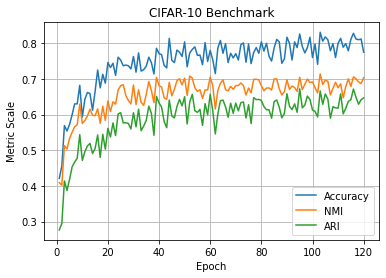

In [9]:
plt.title('CIFAR-10 Benchmark')
plt.plot(log.savelog['Epoch'], log.savelog['ACC'], label='Accuracy')
plt.plot(log.savelog['Epoch'], log.savelog['NMI'], label='NMI')
plt.plot(log.savelog['Epoch'], log.savelog['ARI'], label='ARI')
plt.xlabel('Epoch')
plt.ylabel('Metric Scale')
plt.grid()
plt.legend()
plt.savefig('benchmark_cifar10.png', dpi=300)